In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('mwp1_CAT12_DELCODE/Antrag 137_Teipel_Regional Connectivity_20190429_Amendment_MDedit.xlsx', sheet_name='Baseline', header=1)
#print(df)
sid = df['Respeudonym']
grp = df['prmdiag']
age = df['age']
sex = df['sex_bin_1male']
tiv = df['TIV_CAT12']
field = df['FieldStrength']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataDELCODE_CN = sorted(glob.glob('mwp1_CAT12_DELCODE/0_CN/*.nii.gz'))
dataDELCODE_MCI = sorted(glob.glob('mwp1_CAT12_DELCODE/2_MCI/*.nii.gz'))
dataDELCODE_AD = sorted(glob.glob('mwp1_CAT12_DELCODE/5_AD/*.nii.gz'))
dataFiles = dataDELCODE_CN + dataDELCODE_MCI + dataDELCODE_AD
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  474  nifti files


In [3]:
# Match covariate information
import re
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%s' % id, x)] # extract ID numbers from filename, translate to Excel row index
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load residualized data from disk
import h5py
import numpy as np
from pandas import DataFrame
from keras.utils import to_categorical
hf = h5py.File('residuals_wb_mwp1_MNI_DELCODE.hdf5', 'r')
hf.keys # read keys
labels = np.array(hf.get('labels')) # note: was of data frame type before
images = np.array(hf.get('images'))
hf.close()
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
print(images.shape)

Using TensorFlow backend.


(474, 100, 100, 120, 1)


In [5]:
# specify version of tensorflow
#%tensorflow_version 1.x
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
#print(tf.__version__)
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    # device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = False #True
session = tf.Session(config=config)
set_session(session)

1.15.0


In [6]:
def get_values(conf_matrix):
    assert conf_matrix.shape==(2,2)
    tn, fp, fn, tp = conf_matrix.ravel()
    sen = tp / (tp+fn)
    spec = tn / (fp+tn)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    f1 = 2 * ((sen * spec) / (sen + spec))
    return sen, spec, ppv, npv, f1

validating model newmodel/newmodel_wb_cv1.hdf5
Test accuracy: 71.10 %


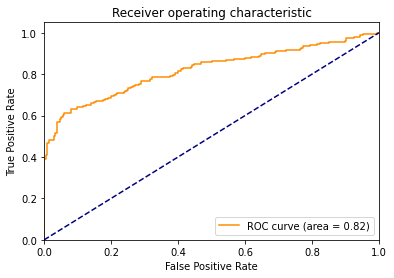

Optimal prediction threshold: 0.98710
Optimal prediction threshold: 0.99721
AUC for MCI vs. CN = 0.74
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.740
AUC for AD vs. CN = 0.936
Acc for MCI vs. CN = 64.9
Acc for AD vs. CN = 72.4
confusion matrix (naive)
[[134  81]
 [  0   0]
 [ 49 106]
 [  7  97]]
oAcc for MCI vs. CN = 73.2
oAcc for AD vs. CN = 91.5
confusion matrix (optimized)
[[197  18]
 [  0   0]
 [ 81  74]
 [ 15  89]]
validating model newmodel/newmodel_wb_cv2.hdf5
Test accuracy: 71.73 %


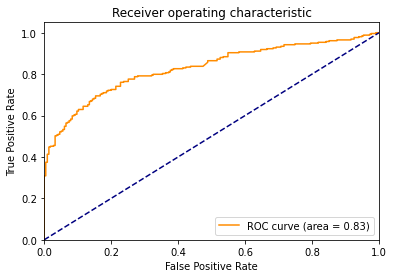

Optimal prediction threshold: 0.88637
Optimal prediction threshold: 0.98238
AUC for MCI vs. CN = 0.76
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.760
AUC for AD vs. CN = 0.931
Acc for MCI vs. CN = 65.4
Acc for AD vs. CN = 70.2
confusion matrix (naive)
[[126  89]
 [  0   0]
 [ 39 116]
 [  6  98]]
oAcc for MCI vs. CN = 72.4
oAcc for AD vs. CN = 88.7
confusion matrix (optimized)
[[166  49]
 [  0   0]
 [ 53 102]
 [ 10  94]]
validating model newmodel/newmodel_wb_cv3.hdf5
Test accuracy: 71.94 %


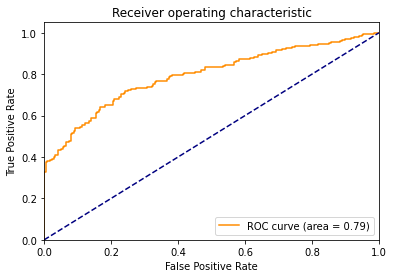

Optimal prediction threshold: 0.75401
Optimal prediction threshold: 0.98374
AUC for MCI vs. CN = 0.72
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.717
AUC for AD vs. CN = 0.908
Acc for MCI vs. CN = 66.5
Acc for AD vs. CN = 77.1
confusion matrix (naive)
[[151  64]
 [  0   0]
 [ 60  95]
 [  9  95]]
oAcc for MCI vs. CN = 68.6
oAcc for AD vs. CN = 86.2
confusion matrix (optimized)
[[166  49]
 [  0   0]
 [ 67  88]
 [ 11  93]]
validating model newmodel/newmodel_wb_cv4.hdf5
Test accuracy: 74.68 %


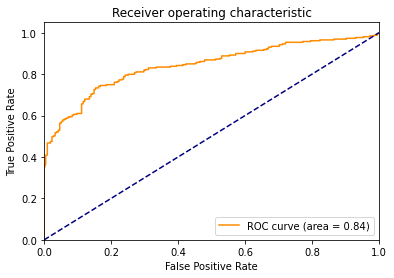

Optimal prediction threshold: 0.82771
Optimal prediction threshold: 0.99080
AUC for MCI vs. CN = 0.78
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.776
AUC for AD vs. CN = 0.940
Acc for MCI vs. CN = 69.5
Acc for AD vs. CN = 73.7
confusion matrix (naive)
[[138  77]
 [  0   0]
 [ 36 119]
 [  7  97]]
oAcc for MCI vs. CN = 73.5
oAcc for AD vs. CN = 88.4
confusion matrix (optimized)
[[163  52]
 [  0   0]
 [ 46 109]
 [  8  96]]
validating model newmodel/newmodel_wb_cv5.hdf5
Test accuracy: 74.89 %


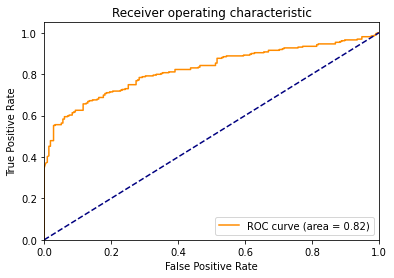

Optimal prediction threshold: 0.95822
Optimal prediction threshold: 0.99899
AUC for MCI vs. CN = 0.74
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.740
AUC for AD vs. CN = 0.947
Acc for MCI vs. CN = 69.5
Acc for AD vs. CN = 77.7
confusion matrix (naive)
[[150  65]
 [  0   0]
 [ 48 107]
 [  6  98]]
oAcc for MCI vs. CN = 73.2
oAcc for AD vs. CN = 91.5
confusion matrix (optimized)
[[190  25]
 [  0   0]
 [ 74  81]
 [ 16  88]]
validating model newmodel/newmodel_wb_cv6.hdf5
Test accuracy: 73.42 %


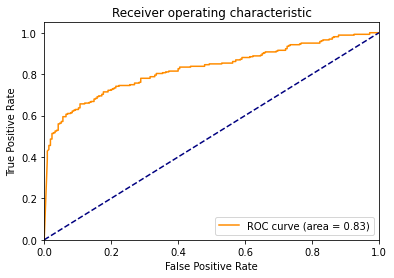

Optimal prediction threshold: 0.96834
Optimal prediction threshold: 0.99969
AUC for MCI vs. CN = 0.75
AUC for AD vs. CN = 0.94
AUC for MCI vs. CN = 0.748
AUC for AD vs. CN = 0.940
Acc for MCI vs. CN = 67.8
Acc for AD vs. CN = 74.0
confusion matrix (naive)
[[139  76]
 [  0   0]
 [ 43 112]
 [  7  97]]
oAcc for MCI vs. CN = 72.4
oAcc for AD vs. CN = 90.9
confusion matrix (optimized)
[[177  38]
 [  0   0]
 [ 64  91]
 [ 11  93]]
validating model newmodel/newmodel_wb_cv7.hdf5
Test accuracy: 72.15 %


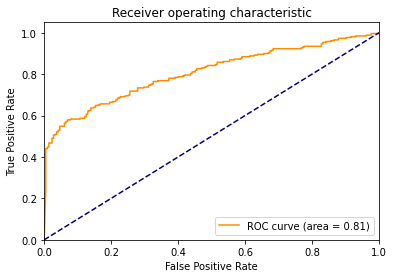

Optimal prediction threshold: 0.97369
Optimal prediction threshold: 0.99394
AUC for MCI vs. CN = 0.72
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.722
AUC for AD vs. CN = 0.930
Acc for MCI vs. CN = 67.0
Acc for AD vs. CN = 78.1
confusion matrix (naive)
[[155  60]
 [  0   0]
 [ 62  93]
 [ 10  94]]
oAcc for MCI vs. CN = 70.0
oAcc for AD vs. CN = 89.3
confusion matrix (optimized)
[[185  30]
 [  0   0]
 [ 81  74]
 [ 15  89]]
validating model newmodel/newmodel_wb_cv8.hdf5
Test accuracy: 73.42 %


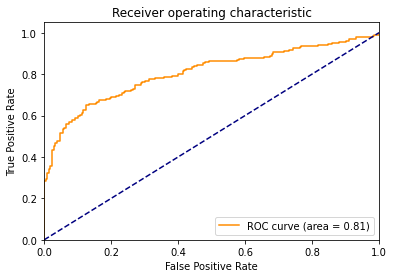

Optimal prediction threshold: 0.46772
Optimal prediction threshold: 0.94362
AUC for MCI vs. CN = 0.73
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.734
AUC for AD vs. CN = 0.914
Acc for MCI vs. CN = 68.6
Acc for AD vs. CN = 76.5
confusion matrix (naive)
[[150  65]
 [  0   0]
 [ 51 104]
 [ 10  94]]
oAcc for MCI vs. CN = 68.6
oAcc for AD vs. CN = 87.1
confusion matrix (optimized)
[[148  67]
 [  0   0]
 [ 49 106]
 [ 10  94]]
validating model newmodel/newmodel_wb_cv9.hdf5
Test accuracy: 73.84 %


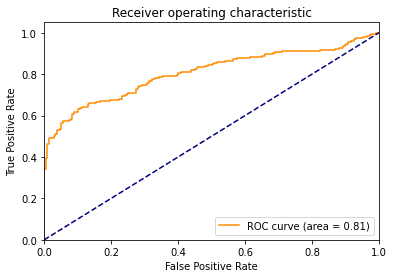

Optimal prediction threshold: 0.66992
Optimal prediction threshold: 0.91836
AUC for MCI vs. CN = 0.73
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.729
AUC for AD vs. CN = 0.920
Acc for MCI vs. CN = 70.3
Acc for AD vs. CN = 83.4
confusion matrix (naive)
[[176  39]
 [  0   0]
 [ 71  84]
 [ 14  90]]
oAcc for MCI vs. CN = 72.2
oAcc for AD vs. CN = 88.4
confusion matrix (optimized)
[[186  29]
 [  0   0]
 [ 74  81]
 [ 15  89]]
validating model newmodel/newmodel_wb_cv10.hdf5
Test accuracy: 70.25 %


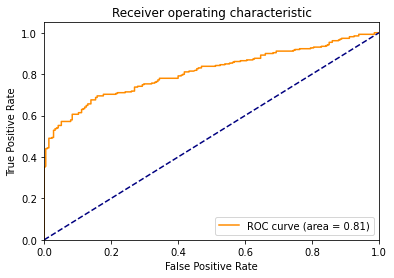

Optimal prediction threshold: 0.95828
Optimal prediction threshold: 0.99174
AUC for MCI vs. CN = 0.74
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.736
AUC for AD vs. CN = 0.922
Acc for MCI vs. CN = 63.8
Acc for AD vs. CN = 69.6
confusion matrix (naive)
[[125  90]
 [  0   0]
 [ 44 111]
 [  7  97]]
oAcc for MCI vs. CN = 71.9
oAcc for AD vs. CN = 88.7
confusion matrix (optimized)
[[181  34]
 [  0   0]
 [ 70  85]
 [ 11  93]]
validating model newmodel/newmodel_wb_cv11.hdf5
Test accuracy: 69.62 %


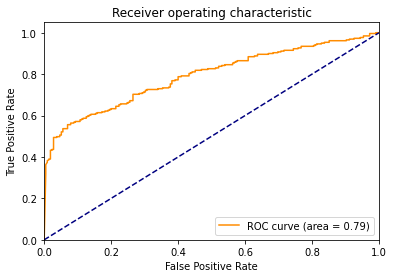

Optimal prediction threshold: 0.95969
Optimal prediction threshold: 0.99896
AUC for MCI vs. CN = 0.70
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.704
AUC for AD vs. CN = 0.919
Acc for MCI vs. CN = 63.2
Acc for AD vs. CN = 69.3
confusion matrix (naive)
[[125  90]
 [  0   0]
 [ 46 109]
 [  8  96]]
oAcc for MCI vs. CN = 66.8
oAcc for AD vs. CN = 88.7
confusion matrix (optimized)
[[158  57]
 [  0   0]
 [ 66  89]
 [ 13  91]]
validating model newmodel/newmodel_wb_cv12.hdf5
Test accuracy: 72.78 %


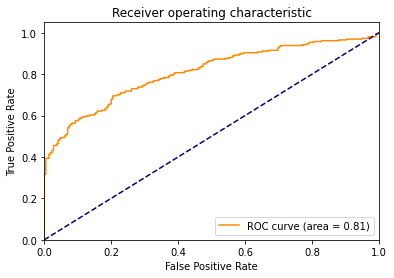

Optimal prediction threshold: 0.86109
Optimal prediction threshold: 0.99426
AUC for MCI vs. CN = 0.73
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.726
AUC for AD vs. CN = 0.932
Acc for MCI vs. CN = 67.6
Acc for AD vs. CN = 76.8
confusion matrix (naive)
[[150  65]
 [  0   0]
 [ 55 100]
 [  9  95]]
oAcc for MCI vs. CN = 69.7
oAcc for AD vs. CN = 87.8
confusion matrix (optimized)
[[171  44]
 [  0   0]
 [ 68  87]
 [ 12  92]]
validating model newmodel/newmodel_wb_cv13.hdf5
Test accuracy: 72.57 %


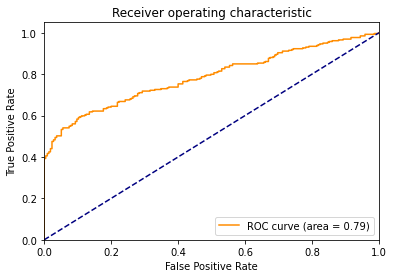

Optimal prediction threshold: 0.75243
Optimal prediction threshold: 0.92466
AUC for MCI vs. CN = 0.69
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.694
AUC for AD vs. CN = 0.922
Acc for MCI vs. CN = 68.6
Acc for AD vs. CN = 85.6
confusion matrix (naive)
[[183  32]
 [  0   0]
 [ 84  71]
 [ 14  90]]
oAcc for MCI vs. CN = 69.5
oAcc for AD vs. CN = 90.0
confusion matrix (optimized)
[[193  22]
 [  0   0]
 [ 91  64]
 [ 16  88]]
validating model newmodel/newmodel_wb_cv14.hdf5
Test accuracy: 71.94 %


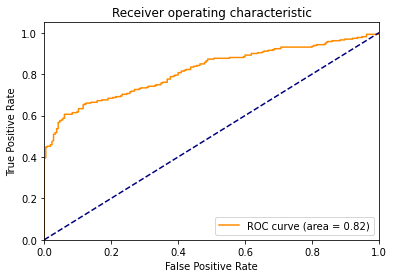

Optimal prediction threshold: 0.99045
Optimal prediction threshold: 0.99866
AUC for MCI vs. CN = 0.73
AUC for AD vs. CN = 0.95
AUC for MCI vs. CN = 0.729
AUC for AD vs. CN = 0.947
Acc for MCI vs. CN = 66.2
Acc for AD vs. CN = 77.4
confusion matrix (naive)
[[151  64]
 [  0   0]
 [ 61  94]
 [  8  96]]
oAcc for MCI vs. CN = 71.9
oAcc for AD vs. CN = 91.2
confusion matrix (optimized)
[[190  25]
 [  0   0]
 [ 79  76]
 [ 12  92]]
validating model newmodel/newmodel_wb_cv15.hdf5
Test accuracy: 69.62 %


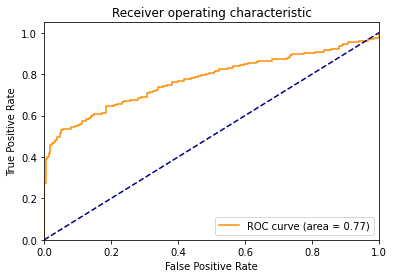

Optimal prediction threshold: 0.95016
Optimal prediction threshold: 0.99456
AUC for MCI vs. CN = 0.68
AUC for AD vs. CN = 0.91
AUC for MCI vs. CN = 0.682
AUC for AD vs. CN = 0.910
Acc for MCI vs. CN = 63.2
Acc for AD vs. CN = 77.7
confusion matrix (naive)
[[152  63]
 [  0   0]
 [ 73  82]
 [  8  96]]
oAcc for MCI vs. CN = 68.4
oAcc for AD vs. CN = 89.3
confusion matrix (optimized)
[[185  30]
 [  0   0]
 [ 87  68]
 [ 19  85]]
validating model newmodel/newmodel_wb_cv16.hdf5
Test accuracy: 72.15 %


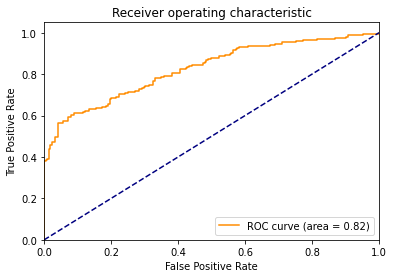

Optimal prediction threshold: 0.97415
Optimal prediction threshold: 0.99362
AUC for MCI vs. CN = 0.75
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.750
AUC for AD vs. CN = 0.935
Acc for MCI vs. CN = 67.0
Acc for AD vs. CN = 78.7
confusion matrix (naive)
[[157  58]
 [  0   0]
 [ 64  91]
 [ 10  94]]
oAcc for MCI vs. CN = 71.9
oAcc for AD vs. CN = 91.2
confusion matrix (optimized)
[[196  19]
 [  0   0]
 [ 85  70]
 [ 17  87]]
validating model newmodel/newmodel_wb_cv17.hdf5
Test accuracy: 71.73 %


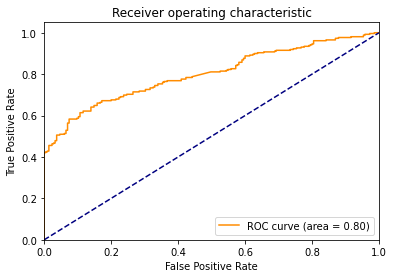

Optimal prediction threshold: 0.77261
Optimal prediction threshold: 0.98490
AUC for MCI vs. CN = 0.72
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.721
AUC for AD vs. CN = 0.918
Acc for MCI vs. CN = 67.3
Acc for AD vs. CN = 76.8
confusion matrix (naive)
[[154  61]
 [  0   0]
 [ 60  95]
 [ 13  91]]
oAcc for MCI vs. CN = 71.1
oAcc for AD vs. CN = 89.3
confusion matrix (optimized)
[[178  37]
 [  0   0]
 [ 70  85]
 [ 16  88]]
validating model newmodel/newmodel_wb_cv18.hdf5
Test accuracy: 73.84 %


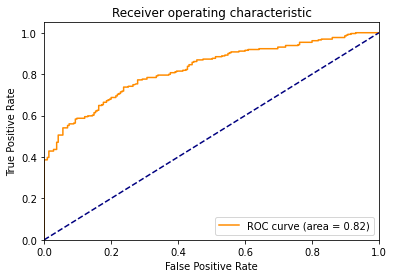

Optimal prediction threshold: 0.45246
Optimal prediction threshold: 0.98359
AUC for MCI vs. CN = 0.75
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.752
AUC for AD vs. CN = 0.927
Acc for MCI vs. CN = 70.0
Acc for AD vs. CN = 79.9
confusion matrix (naive)
[[164  51]
 [  0   0]
 [ 60  95]
 [ 13  91]]
oAcc for MCI vs. CN = 70.8
oAcc for AD vs. CN = 88.4
confusion matrix (optimized)
[[164  51]
 [  0   0]
 [ 57  98]
 [ 12  92]]
validating model newmodel/newmodel_wb_cv19.hdf5
Test accuracy: 68.35 %


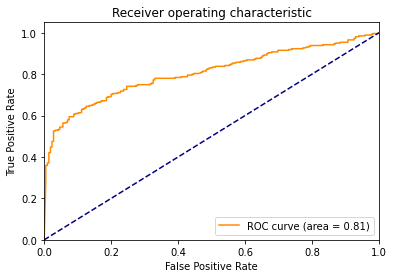

Optimal prediction threshold: 0.95667
Optimal prediction threshold: 0.99691
AUC for MCI vs. CN = 0.72
AUC for AD vs. CN = 0.92
AUC for MCI vs. CN = 0.725
AUC for AD vs. CN = 0.925
Acc for MCI vs. CN = 61.4
Acc for AD vs. CN = 66.8
confusion matrix (naive)
[[116  99]
 [  0   0]
 [ 44 111]
 [  7  97]]
oAcc for MCI vs. CN = 70.5
oAcc for AD vs. CN = 89.0
confusion matrix (optimized)
[[171  44]
 [  0   0]
 [ 65  90]
 [ 12  92]]
validating model newmodel/newmodel_wb_cv20.hdf5
Test accuracy: 73.63 %


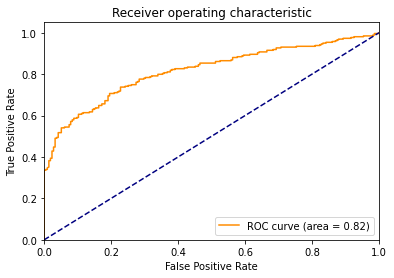

Optimal prediction threshold: 0.87749
Optimal prediction threshold: 0.99222
AUC for MCI vs. CN = 0.74
AUC for AD vs. CN = 0.93
AUC for MCI vs. CN = 0.737
AUC for AD vs. CN = 0.933
Acc for MCI vs. CN = 67.6
Acc for AD vs. CN = 76.2
confusion matrix (naive)
[[144  71]
 [  0   0]
 [ 49 106]
 [  5  99]]
oAcc for MCI vs. CN = 70.8
oAcc for AD vs. CN = 87.1
confusion matrix (optimized)
[[166  49]
 [  0   0]
 [ 59  96]
 [ 11  93]]


In [7]:
# Split data into training/validation and holdout test data
from sklearn.model_selection import StratifiedKFold,train_test_split
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # model will be trained on GPU 0

import keras
from keras import layers
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.optimizers import Adam
from keras import initializers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from statistics import mean,stdev
from sklearn.metrics import confusion_matrix

acc_test, auc_test, auc_AD, auc_MCI = [], [], [], []
acc_AD, acc_MCI, opt_acc_AD, opt_acc_MCI = [], [], [], []
sen_AD, sen_MCI, spec_AD, spec_MCI = [], [], [], []
ppv_AD, ppv_MCI, npv_AD, npv_MCI = [], [], [], []
opt_ppv_AD, opt_ppv_MCI, opt_npv_AD, opt_npv_MCI = [], [], [], []
opt_sen_AD, opt_sen_MCI, opt_spec_AD, opt_spec_MCI = [], [], [], []
f1_AD, f1_MCI, opt_f1_AD, opt_f1_MCI = [], [], [], []

num_kfold = 20 # number of cross-validation loops equal to number of models
batch_size = 8

for k in range(num_kfold):
    gc.collect()
    print('validating model newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    mymodel = models.load_model('newmodel/newmodel_wb_cv%d.hdf5' % (k+1))
    
    # Calculate accuracy for validation data
    #scores = mymodel.evaluate(images, labels, batch_size=batch_size) #, verbose=0
    #print("Test %s: %.2f%%" % (mymodel.metrics_names[1], scores[1]*100))
    #acc_test.append(scores[1]*100)
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    pred = mymodel.predict(images, batch_size=batch_size)
    acc_all = np.mean((labels[:, 1] == np.round(pred[:, 1])).astype(int))*100
    print("Test accuracy: %.2f %%" % acc_all)
    acc_test.append(acc_all)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    acc = dict()
    opt_acc = dict()
    thresh = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    auc_test.append(roc_auc[1])
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    for i in [2,5]:
      grpi = np.equal(grps.Group.to_numpy(dtype=np.int), np.ones((grps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(grps.Group.to_numpy(dtype=np.int), np.zeros((grps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], thresholds = roc_curve(labels[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])
      thresh[i] = thresholds[np.argmax(tpr[i] - fpr[i])]
      print('Optimal prediction threshold: %0.5f' % thresh[i])
      acc[i] = np.mean((labels[grpidx, 1] == np.round(pred[grpidx, 1])).astype(int))*100
      opt_acc[i] = np.mean((labels[grpidx, 1] == (pred[grpidx, 1]>thresh[i]).astype(int)).astype(int))*100

    print('AUC for MCI vs. CN = %0.2f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.2f' % roc_auc[5])
    auc_AD.append(roc_auc[5])
    auc_MCI.append(roc_auc[2])
    acc_AD.append(acc[5])
    acc_MCI.append(acc[2])
    opt_acc_AD.append(opt_acc[5])
    opt_acc_MCI.append(opt_acc[2])
    
    print('AUC for MCI vs. CN = %0.3f' % roc_auc[2])
    print('AUC for AD vs. CN = %0.3f' % roc_auc[5])
    print('Acc for MCI vs. CN = %0.1f' % acc[2])
    print('Acc for AD vs. CN = %0.1f' % acc[5])
    print('confusion matrix (naive)')
    confmat = confusion_matrix(grps.Group, np.round(pred[:, 1]))
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    sen_MCI.append(sen); spec_MCI.append(spec); ppv_MCI.append(ppv); npv_MCI.append(npv); f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    sen_AD.append(sen); spec_AD.append(spec); ppv_AD.append(ppv); npv_AD.append(npv); f1_AD.append(f1)
    print(confmat[:,(0,1)])
    print('oAcc for MCI vs. CN = %0.1f' % opt_acc[2])
    print('oAcc for AD vs. CN = %0.1f' % opt_acc[5])
    print('confusion matrix (optimized)')
    confmat = confusion_matrix(grps.Group, (pred[:, 1]>thresh[2]).astype(int)) ## use MCI threshold
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,2),0:2]) # MCI
    opt_sen_MCI.append(sen); opt_spec_MCI.append(spec); opt_ppv_MCI.append(ppv); opt_npv_MCI.append(npv); opt_f1_MCI.append(f1)
    sen, spec, ppv, npv, f1 = get_values(confmat[(0,3),0:2]) # AD
    opt_sen_AD.append(sen); opt_spec_AD.append(spec); opt_ppv_AD.append(ppv); opt_npv_AD.append(npv); opt_f1_AD.append(f1)
    print(confmat[:,(0,1)])

In [8]:
# print model performance summary
from statistics import mean,stdev
print('Acc for all test data = %0.1f +/- %0.1f' % (mean(acc_test), stdev(acc_test)))
print('AUC for all test data = %0.3f +/- %0.3f' % (mean(auc_test), stdev(auc_test)))
print('AUC for MCI vs. CN = %0.3f +/- %0.3f' % (mean(auc_MCI), stdev(auc_MCI)))
print('AUC for AD vs. CN = %0.3f +/- %0.3f' % (mean(auc_AD), stdev(auc_AD)))
print('Mean Acc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(acc_MCI), stdev(acc_MCI)))
print('Mean Acc for AD vs. CN = %0.1f +/- %0.1f' % (mean(acc_AD), stdev(acc_AD)))
print('Mean oAcc for MCI vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_MCI), stdev(opt_acc_MCI)))
print('Mean oAcc for AD vs. CN = %0.1f +/- %0.1f' % (mean(opt_acc_AD), stdev(opt_acc_AD)))

Acc for all test data = 72.2 +/- 1.7
AUC for all test data = 0.810 +/- 0.016
AUC for MCI vs. CN = 0.731 +/- 0.022
AUC for AD vs. CN = 0.928 +/- 0.011
Mean Acc for MCI vs. CN = 66.8 +/- 2.5
Mean Acc for AD vs. CN = 75.9 +/- 4.7
Mean oAcc for MCI vs. CN = 70.9 +/- 1.9
Mean oAcc for AD vs. CN = 89.2 +/- 1.5


In [9]:
results = pd.DataFrame({'Accuracy_Test':acc_test, 'AUC_Test':auc_test, 'AUC_MCI':auc_MCI, 'AUC_AD':auc_AD,
                        'Acc_MCI':acc_MCI, 'Acc_AD':acc_AD,
                        'Opt_acc_MCI':opt_acc_MCI, 'Opt_acc_AD':opt_acc_AD})
print(results)

    Accuracy_Test  AUC_Test   AUC_MCI    AUC_AD    Acc_MCI     Acc_AD  \
0       71.097046  0.818802  0.740075  0.936136  64.864865  72.413793   
1       71.729958  0.828688  0.760315  0.930590  65.405405  70.219436   
2       71.940928  0.793391  0.716669  0.907737  66.486486  77.115987   
3       74.683544  0.842022  0.776099  0.940273  69.459459  73.667712   
4       74.894515  0.822753  0.739595  0.946691  69.459459  77.742947   
5       73.417722  0.825249  0.748357  0.939848  67.837838  73.981191   
6       72.151899  0.805558  0.722191  0.929808  67.027027  78.056426   
7       73.417722  0.806303  0.733893  0.914222  68.648649  76.489028   
8       73.839662  0.805944  0.729272  0.920215  70.270270  83.385580   
9       70.253165  0.810874  0.736069  0.922361  63.783784  69.592476   
10      69.620253  0.790419  0.704126  0.919030  63.243243  69.278997   
11      72.784810  0.808521  0.725641  0.932044  67.567568  76.802508   
12      72.573840  0.785283  0.693563  0.921981  68

In [10]:
print('Mean Sen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(sen_MCI), stdev(sen_MCI)))
print('Mean Sen for AD vs. CN = %0.3f +/- %0.3f' % (mean(sen_AD), stdev(sen_AD)))
print('Mean oSen for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_MCI), stdev(opt_sen_MCI)))
print('Mean oSen for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_sen_AD), stdev(opt_sen_AD)))

print('Mean Spec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(spec_MCI), stdev(spec_MCI)))
print('Mean Spec for AD vs. CN = %0.3f +/- %0.3f' % (mean(spec_AD), stdev(spec_AD)))
print('Mean oSpec for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_MCI), stdev(opt_spec_MCI)))
print('Mean oSpec for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_spec_AD), stdev(opt_spec_AD)))

print('Mean PPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(ppv_MCI), stdev(ppv_MCI)))
print('Mean PPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(ppv_AD), stdev(ppv_AD)))
print('Mean oPPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_MCI), stdev(opt_ppv_MCI)))
print('Mean oPPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_ppv_AD), stdev(opt_ppv_AD)))

print('Mean NPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(npv_MCI), stdev(npv_MCI)))
print('Mean NPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(npv_AD), stdev(npv_AD)))
print('Mean oNPV for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_MCI), stdev(opt_npv_MCI)))
print('Mean oNPV for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_npv_AD), stdev(opt_npv_AD)))

print('Mean F1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(f1_MCI), stdev(f1_MCI)))
print('Mean F1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(f1_AD), stdev(f1_AD)))
print('Mean oF1 for MCI vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_MCI), stdev(opt_f1_MCI)))
print('Mean oF1 for AD vs. CN = %0.3f +/- %0.3f' % (mean(opt_f1_AD), stdev(opt_f1_AD)))

Mean Sen for MCI vs. CN = 0.645 +/- 0.079
Mean Sen for AD vs. CN = 0.914 +/- 0.026
Mean oSen for MCI vs. CN = 0.553 +/- 0.081
Mean oSen for AD vs. CN = 0.874 +/- 0.027
Mean Spec for MCI vs. CN = 0.684 +/- 0.079
Mean Spec for AD vs. CN = 0.684 +/- 0.079
Mean oSpec for MCI vs. CN = 0.821 +/- 0.064
Mean oSpec for AD vs. CN = 0.821 +/- 0.064
Mean PPV for MCI vs. CN = 0.601 +/- 0.041
Mean PPV for AD vs. CN = 0.590 +/- 0.059
Mean oPPV for MCI vs. CN = 0.699 +/- 0.054
Mean oPPV for AD vs. CN = 0.711 +/- 0.071
Mean NPV for MCI vs. CN = 0.730 +/- 0.027
Mean NPV for AD vs. CN = 0.944 +/- 0.012
Mean oNPV for MCI vs. CN = 0.720 +/- 0.025
Mean oNPV for AD vs. CN = 0.931 +/- 0.011
Mean F1 for MCI vs. CN = 0.656 +/- 0.028
Mean F1 for AD vs. CN = 0.779 +/- 0.044
Mean oF1 for MCI vs. CN = 0.654 +/- 0.041
Mean oF1 for AD vs. CN = 0.845 +/- 0.027
